In [1]:
import rdflib
import loader
import discourse
import pandas as pd
from rdflib import Graph, Namespace
from rdflib.namespace import RDF, RDFS

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#Contains belongs to more than one entity types: [owl.ObjectProperty, owl.ObjectProperty, owl.ObjectProperty, datamodels_rdf.MetaProperty]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#MemberOf belongs to more than one entity types: [owl.ObjectProperty, owl.ObjectProperty, owl.ObjectProperty, datamodels_rdf.MetaProperty]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/tomk/ontologies/2022/9/datamodel#RelationshipFromAttribute belongs to more than one entity types: [owl.ObjectProperty, datamodels_rdf.MetaProperty, datamodels_rdf.RelationshipLinkage]; I'm trying to fix it...
* Owlready2 * WARNING: ObjectProperty http://www.semanticweb.org/to

datamodels_rdf.Mapping_Attribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_AttributeHasDataType [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Class [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ClassContainsAttribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Context [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ContextContainsClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ContextContainsSubContext [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_DomainContainsModel [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_FromAttribute [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_FromClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_Model [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsClass [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsContext [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelContainsRelationship [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelDomain [datamodels_rdf.Mapping]
datamodels_rdf.Mapping_ModelHasModelT

* Owlready2 * HermiT took 0.6596910953521729 seconds
* Owlready * Reparenting discourse.Predicate: {discourse.Atom, owl.ObjectProperty} => {discourse.Atom}
* Owlready * Reparenting discourse.Subject: {discourse.Atom, owl.ObjectProperty} => {discourse.Atom}
* Owlready * Reparenting discourse.Object: {discourse.Atom, owl.ObjectProperty} => {discourse.Atom}
* Owlready * Reparenting datamodels_rdf.RelationshipFromAttribute: {datamodels_rdf.RelationshipLinkage, owl.ObjectProperty} => {datamodels_rdf.RelationshipLinkage, datamodels_rdf.MetaProperty}
* Owlready * Reparenting datamodels_rdf.RelationshipToOptionality: {datamodels_rdf.RelationshipLinkage, owl.ObjectProperty} => {datamodels_rdf.RelationshipLinkage}
* Owlready * Reparenting datamodels_rdf.RelationshipToClass: {datamodels_rdf.RelationshipLinkage, owl.ObjectProperty} => {datamodels_rdf.RelationshipLinkage, datamodels_rdf.MetaProperty}
* Owlready * Reparenting datamodels_rdf.RelationshipFromClass: {datamodels_rdf.RelationshipLinkage,

In [2]:
import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot
from IPython.core.display import HTML


def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()

    display(Image(png))

def t2rdflibg(triples): #triples to rdflib graph
    g = Graph()
    for t in triples:
        g.add(t)
    return g


In [3]:

def nan2None(value):
    if pd.isnull(value) :
        return None
    else:
        return value


def get_data_rows(filename):
    data_rows_df = pd.read_csv(filename)
    data_rows=[]
    for i,r in data_rows_df.iterrows():
        r_d = {k:nan2None(v) for k,v in dict(r).items()}

        data_rows.append(r_d)
    del data_rows_df
    return data_rows


In [4]:
serial_key = { "Business Domain" : "ModelDomain", 
             "Model" : "Model", 
             "ModelType" : "ModelType", 
             "Entity" : "Class", 
             "Attribute" : "Attribute", 
             "DataType" : "DataType", 
             "Context" : "Context", 
             "SubContext" : "SubContext", 
             "Relationship" : "Relationship", 
             "Entity From" : "FromClass",
             "Attribute From" : "FromAttribute", 
             "Cardinality From" : "FromCardinality",
             "Entity To" : "ToClass",
             "Attribute To" : "ToAttribute",
             "Cardinality To" : "ToCardinality"
}
# job_def is in the form (Serialization, key, data )
job_def_load_entities = ("Entity Load", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("model_entities.csv")  )
batch_manifest = [job_def_load_entities]

In [5]:
# Create Empty Graph
test = Graph()
test.parse ("datamodels_rdf.owl", format='xml')
test.parse ("discourse.owl", format='xml')
dmns = Namespace(loader.onto.base_iri)
test.bind('dm', dmns, override=True, replace=True)
discns = Namespace(discourse.onto.base_iri)
test.bind('disc', discns, override=True, replace=True)

test.bind('rdfs', RDFS)
#namespace_d = {'dm': dmns, 'rdfs' : RDFS, 'rdf' : RDF}

In [6]:
qtest = loader.load_data("test", batch_manifest=batch_manifest, rdflib_graph=test)

In [7]:

data_load_objects_sparql = """
SELECT (count(?s) as ?count) ?t
WHERE 
    {
        ?s a ?t .
    }
GROUP BY ?t
"""
results = qtest.query(data_load_objects_sparql)

In [8]:
sorted(filter(lambda f: any([x in f[0] for x in ["discourse", "datamodel"]]),[("/".join(r[1].toPython().split("/")[-1:]), r[0].toPython())  for r in results]), key=lambda x: x[1])[::-1]


[('discourse#Declaration', 360),
 ('discourse#Posit', 128),
 ('datamodel#Mapping', 26),
 ('discourse#Discourse', 22),
 ('datamodel#RowNode', 20),
 ('datamodel#Attribute', 14),
 ('datamodel#MetaProperty', 6),
 ('datamodel#MetaDataProperty', 6),
 ('datamodel#MetaClass', 6),
 ('datamodel#Class', 4),
 ('datamodel#Relationship', 3),
 ('datamodel#Serialization', 2),
 ('datamodel#Context', 2),
 ('datamodel#ModelDomain', 1),
 ('datamodel#Model', 1),
 ('datamodel#JobNode', 1),
 ('datamodel#BatchNode', 1)]

In [9]:
job_def_load_entities = ("Entity Load 2", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("model_entities_v2.csv")  )
batch_manifest = [job_def_load_entities]
qtest = loader.load_data("test_v2", batch_manifest=batch_manifest, rdflib_graph=qtest)


In [10]:

data_load_objects_sparql = """
SELECT (count(?s) as ?count) ?t
WHERE 
    {
        ?s a ?t .
    }
GROUP BY ?t
"""
results = qtest.query(data_load_objects_sparql)
sorted(filter(lambda f: any([x in f[0] for x in ["discourse", "datamodel"]]),[("/".join(r[1].toPython().split("/")[-1:]), r[0].toPython())  for r in results]), key=lambda x: x[1])[::-1]



[('discourse#Declaration', 648),
 ('discourse#Posit', 133),
 ('discourse#Discourse', 41),
 ('datamodel#RowNode', 37),
 ('datamodel#Mapping', 26),
 ('datamodel#Attribute', 15),
 ('datamodel#MetaClass', 6),
 ('datamodel#MetaDataProperty', 6),
 ('datamodel#MetaProperty', 6),
 ('datamodel#Class', 4),
 ('datamodel#Relationship', 3),
 ('datamodel#BatchNode', 2),
 ('datamodel#Context', 2),
 ('datamodel#JobNode', 2),
 ('datamodel#Serialization', 2),
 ('datamodel#ModelDomain', 1),
 ('datamodel#Model', 1)]

In [11]:
q="""SELECT ?batch_node 
WHERE {
    ?batch_node a dm:BatchNode.
}"""
batch_nodes = list(qtest.query(q))
batch_nodes

[(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/089aecd23a454698a81c32ec086a2271')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/ea3212054455438dacb74c7cb8523223'))]

In [12]:
# Retrieve s,p,o digests from declared posits linked to individual data loads. 

discourse_q = """       SELECT ?digest
                        WHERE 
                            {
                                BIND (%%bn%% as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }
                        """

qq = discourse_q.replace("%%bn%%", batch_nodes[0][0].n3())
print(qq)
results = qtest.query(qq)
b_0_results = set(results)
print(len(b_0_results))

qq = discourse_q.replace("%%bn%%", batch_nodes[1][0].n3())
print(qq)
results = qtest.query(qq)
b_1_results = set(results)
print(len(b_1_results))
#visualize(t2rdflibg(results))

       SELECT ?digest
                        WHERE 
                            {
                                BIND (<http://www.semanticweb.org/tomk/ontologies/2022/9/089aecd23a454698a81c32ec086a2271> as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:MemberOf ?job_node.
                                ?row_node disc:Proposes ?discourse.
                                ?discourse disc:DiscourseContains ?decl.
                                ?decl disc:Posits ?p.
                                ?p disc:Digest ?digest
                            }
                        
104
       SELECT ?digest
                        WHERE 
                            {
                                BIND (<http://www.semanticweb.org/tomk/ontologies/2022/9/ea3212054455438dacb74c7cb8523223> as ?batch_node).
                                ?job_node dm:MemberOf ?batch_node.
                                ?row_node dm:M

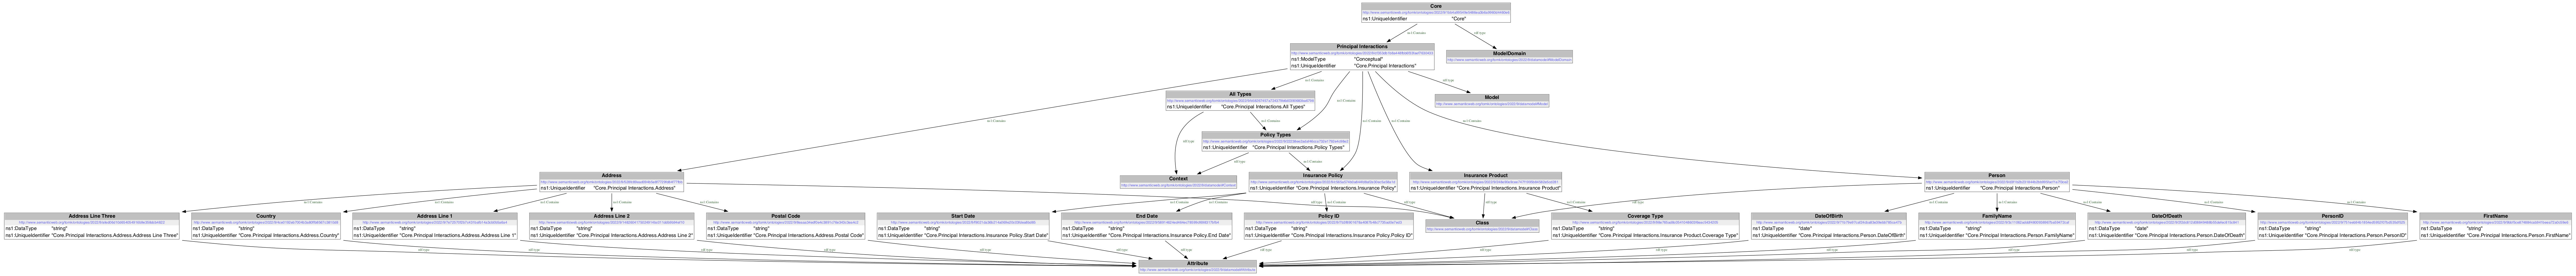

In [13]:

r_triples_0=[discourse.longform_to_triple(r[0]) for r in b_0_results]
visualize(t2rdflibg(r_triples_0))

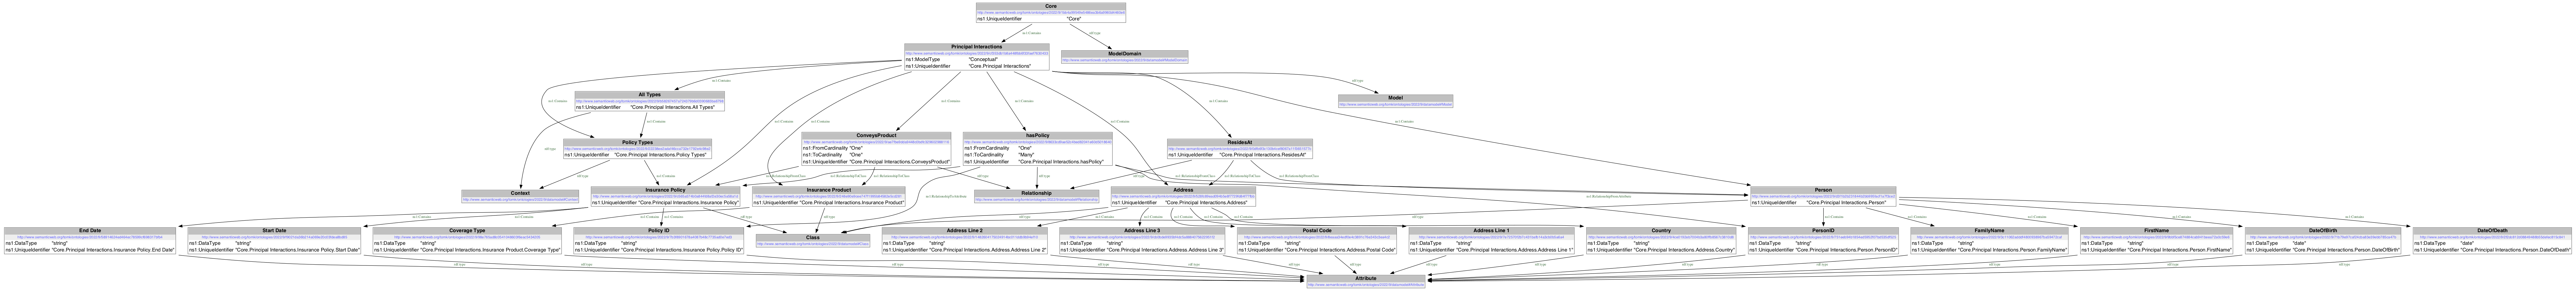

In [14]:
r_triples_1=[discourse.longform_to_triple(r[0]) for r in b_1_results]
visualize(t2rdflibg(r_triples_1))

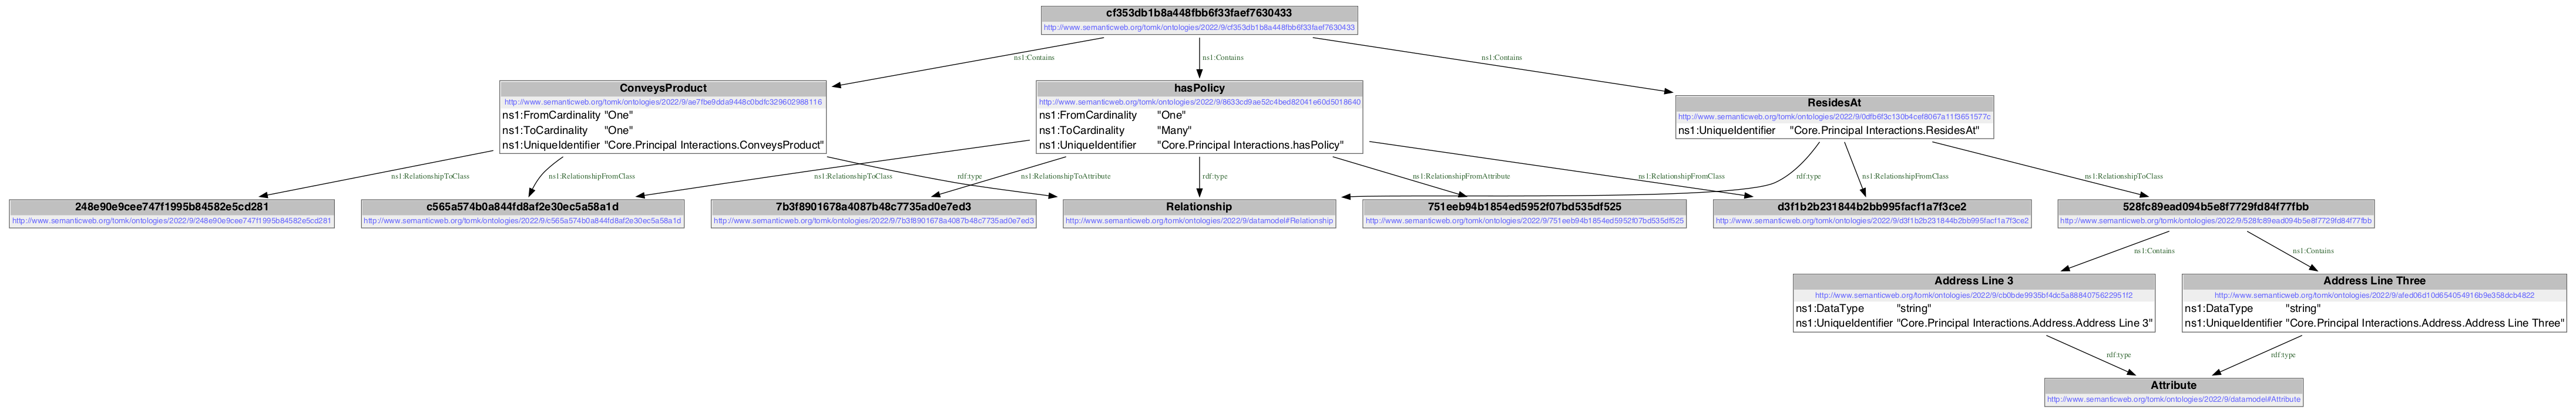

In [15]:
visualize(t2rdflibg(set(r_triples_0).symmetric_difference(set(r_triples_1))))

In [16]:
job_def_load_entities = ("Entity Load 3", loader.onto.EntityAttributeRecord , serial_key, get_data_rows("sample/db_entities.csv")  )
batch_manifest = [job_def_load_entities]
qtest = loader.load_data("sample database", batch_manifest=batch_manifest, rdflib_graph=qtest)


In [17]:
batch_nodes = list(qtest.query(q))
batch_nodes

[(rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/27b66f0e4e9b43faaa9b673429d9d3c3')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/089aecd23a454698a81c32ec086a2271')),
 (rdflib.term.URIRef('http://www.semanticweb.org/tomk/ontologies/2022/9/ea3212054455438dacb74c7cb8523223'))]

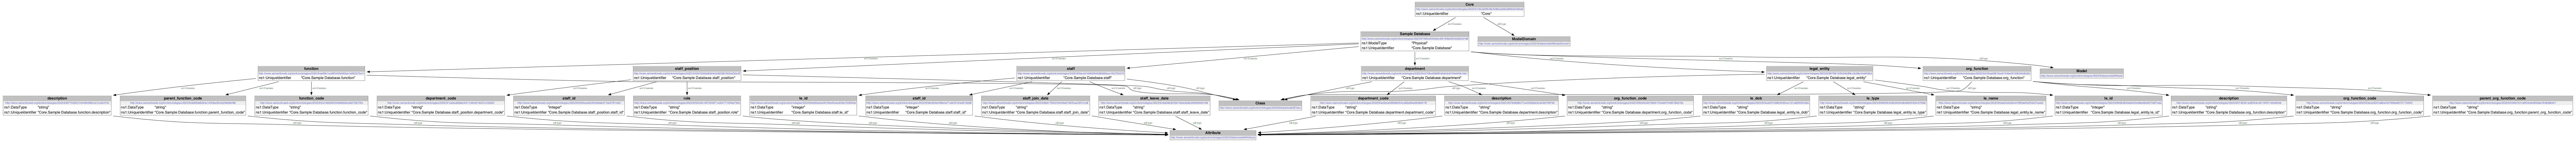

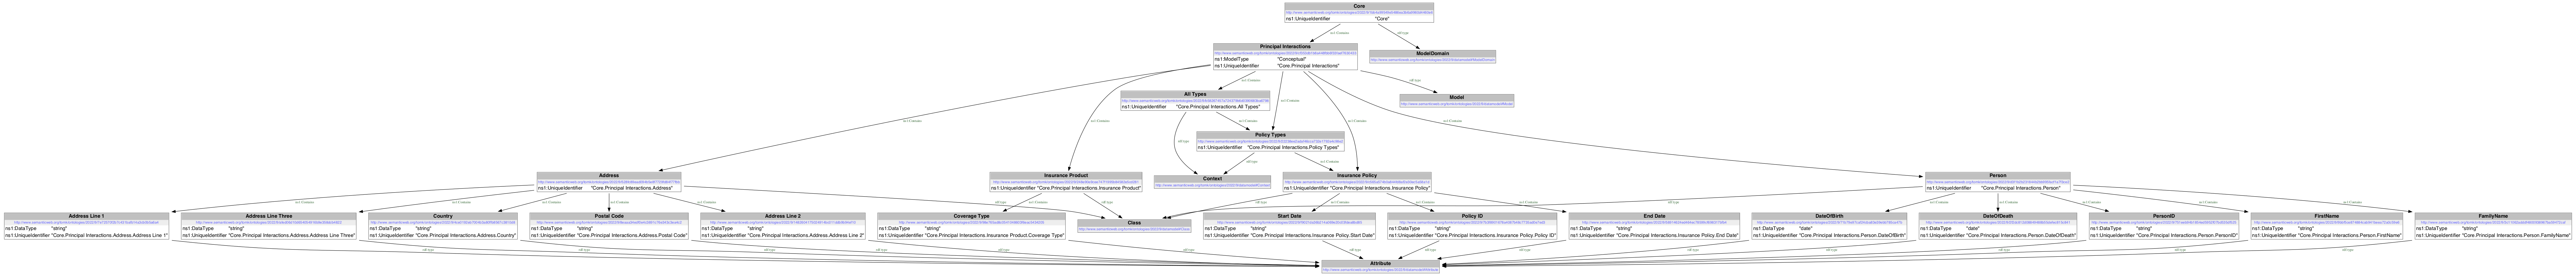

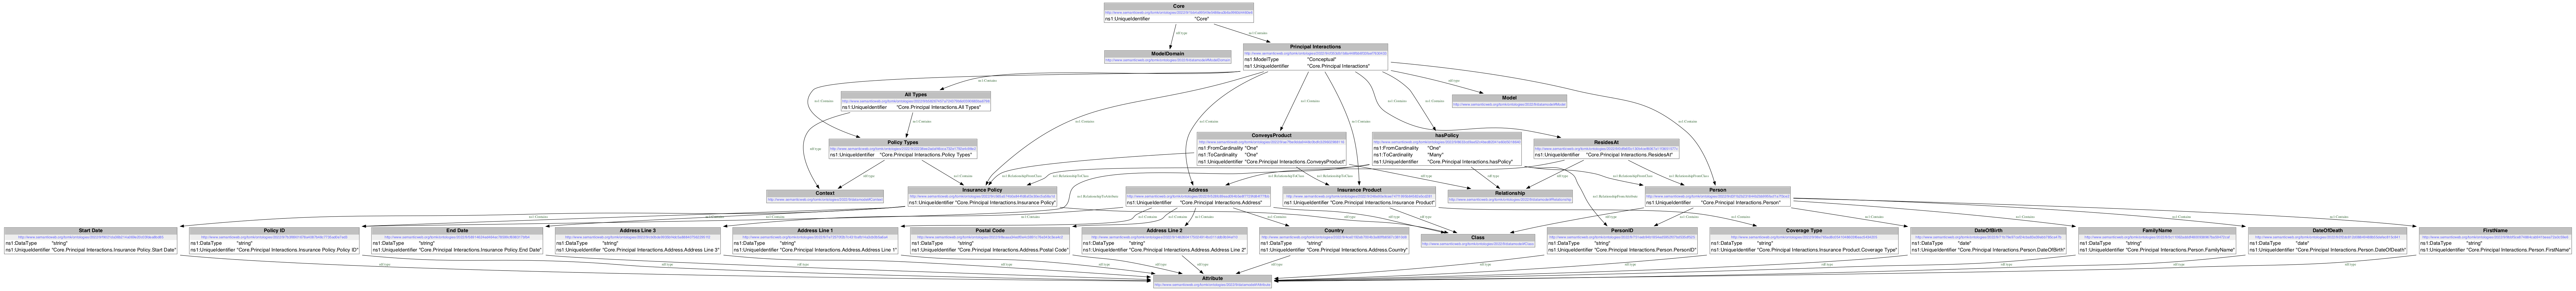

In [18]:
batch_triples=[]
for e,n in enumerate(batch_nodes):
    qq = discourse_q.replace("%%bn%%", n[0].n3())
    results = qtest.query(qq)
    batch_triples.append([discourse.longform_to_triple(r[0]) for r in results])
    visualize(t2rdflibg(batch_triples[e]))

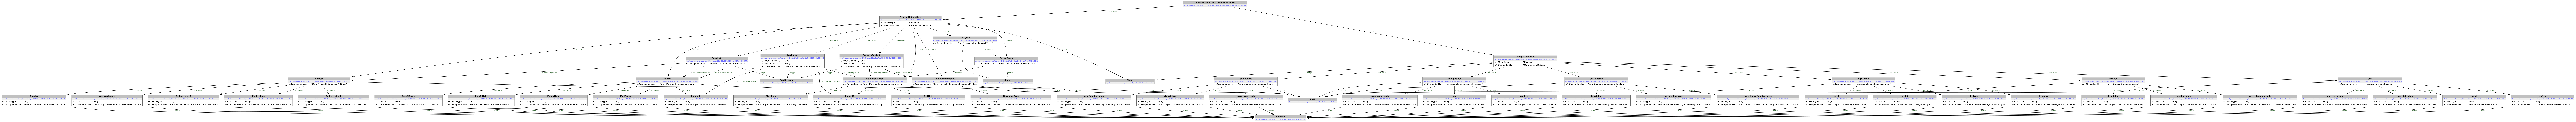

In [19]:
visualize(t2rdflibg(set(batch_triples[0]).symmetric_difference(set(batch_triples[2]))))

In [20]:
# ToDo: Create a set of relationship data for these sample datasets that can be uploaded as part of a batch
# This will demonstrate how multiple datasets/types can be uploaded under the same "batch" header.
# Enabling a fully defined model to be defined and compared against another model. 

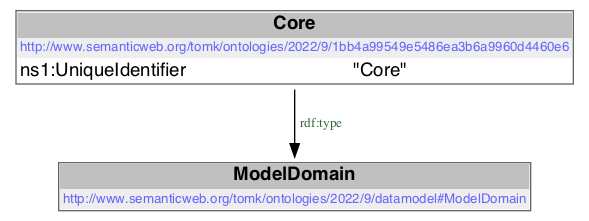

In [21]:
visualize(t2rdflibg(set(batch_triples[0]).intersection(set(batch_triples[2]))))

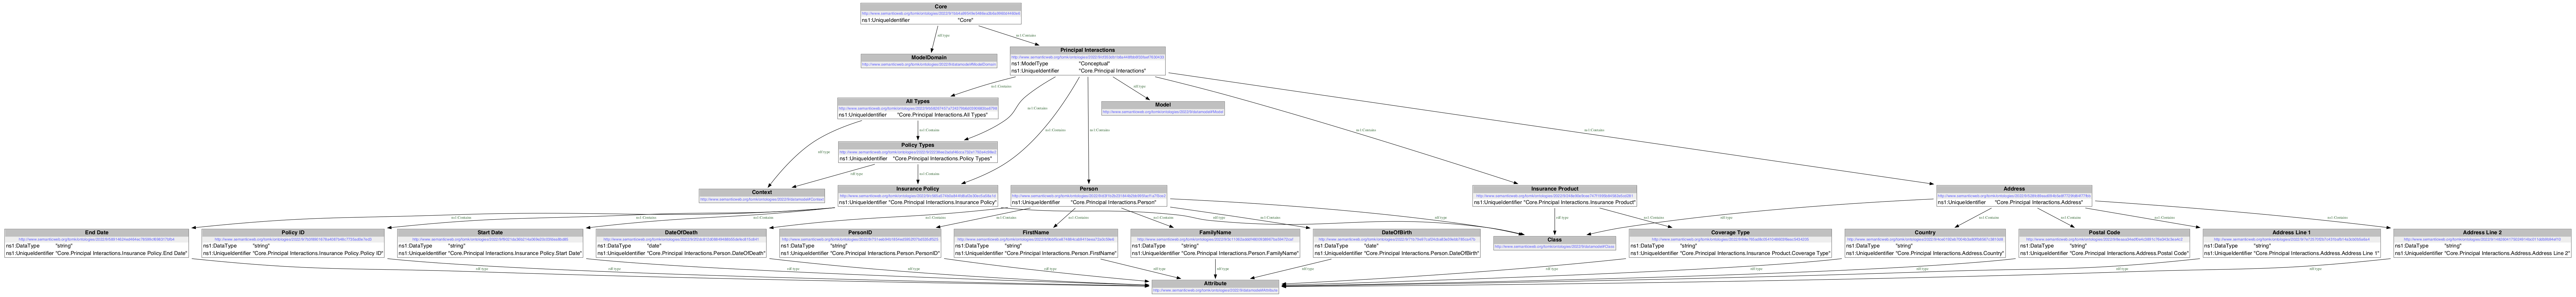

In [22]:
# Intersection of contents shows common values (no change between updates)
visualize(t2rdflibg(set(batch_triples[1]).intersection(set(batch_triples[2]))))

Remove


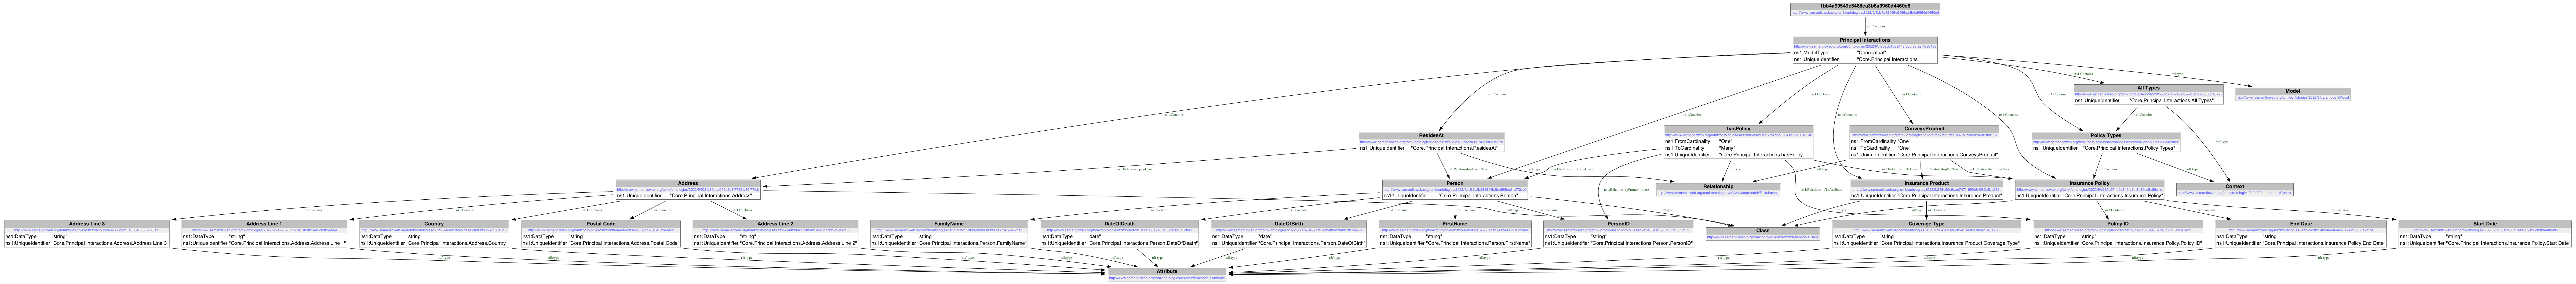

Add


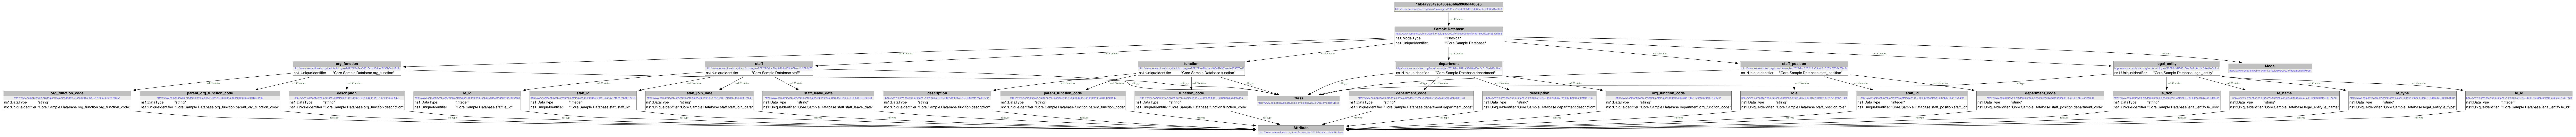

In [23]:
print("Remove")
visualize(t2rdflibg(set(batch_triples[2]).difference(set(batch_triples[0]))))
print("Add")
visualize(t2rdflibg(set(batch_triples[0]).difference(set(batch_triples[2]))))